
## Step 0: Import Datasets

The following cell code imports the datasets, splits into training, validation and test sets.

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

/home/gouravsharan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

A dataset of human images are imported, where the file paths are stored in the numpy array 'human_files'`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


## Step 1: Detect Humans

OpenCV's implementation of Haar feature-based cascade classifiers is used. A sample image is loaded and face(s) are marked in a box.

Number of faces detected: 1


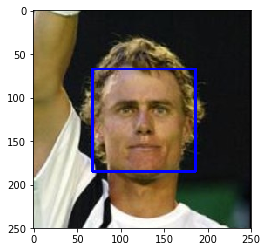

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Images are first converted into grayscale. The 'detectMultiScale' function executes the classifier stored in 'face_cascade' and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

human_in_humans = 0
human_in_dogs = 0
for i in range(100):
    detect1 = face_detector(human_files_short[i])
    if detect1 == True :
        human_in_humans += 1
    detect2 = face_detector(dog_files_short[i])
    if detect2 == True :
        human_in_dogs += 1
print (str(human_in_humans) + " % of the first 100 images in human_files have a detected human face")
print (str(human_in_dogs) + " % of the first 100 images in dog_files have a detected human face")

97 % of the first 100 images in human_files have a detected human face
12 % of the first 100 images in dog_files have a detected human face


The human face detector is tested in a sample dataset of humans as well as of dogs. The algorithm detects human faces in dog files as well. This is because, the classifier is trained only on human faces to detect human facial features. Hence there is a significant error in the dog files.

## Step 2: Detect Dogs

A pre-trained  model, Resnet50 (http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) is used to detect dogs in images. 

In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Dog Detector
In the Imagenet dictionary, the entries from 151 to 268 contain the images of dogs.
We use this idea to write a 'dog_detector' function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [10]:
dog_in_humans = 0
dog_in_dogs = 0
for i in range(100):
    detect1 = dog_detector(human_files_short[i])
    if detect1 == True :
        dog_in_humans += 1
    detect2 = dog_detector(dog_files_short[i])
    if detect2 == True :
        dog_in_dogs += 1
print (str(dog_in_humans) + " % of the first 100 images in human_files have a detected dog")
print (str(dog_in_dogs) + " % of the first 100 images in dog_files have a detected dog")

1 % of the first 100 images in human_files have a detected dog
100 % of the first 100 images in dog_files have a detected dog


The accuracy has significantly increased relative to that of human detector. This is because, the above algorithm is trained on multiple classes of images. 

## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)


### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:06<00:00, 131.15it/s]


In [5]:
print(train_tensors.shape)

(6680, 224, 224, 3)


The above ouput will be used in providing input to the CNN architecture.

In [12]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
img_train = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
img_valid = ImageDataGenerator(rotation_range = 10,
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
img_train.fit(train_tensors)
img_valid.fit(valid_tensors)

The above step is the Image augmentation step. Since we have quite a small number of images to train, augmentation is used, where each image is rotated, shifted horizontally and vertically. Thus increasing the number of input images for the CNN to train.

### Model Architecture

Step 1: Determine the input shape of the images. This has been done as it is a required hyper-parameter input in the first layer of CNN architecture.

Step 2: Introduce the first CNN layer with the determined input_shape (224,224,3) i.e each image is of the height and width = 224 pixels with depth = 3( color image, each unit of depth corresponds to RED ,GREEN and BLUE spatial values). Since the input shape is quite larger than those used in the classroom sessions, filter size has been given 4x4 rather than 2x2. As taught in the classroom, padding = 'same' has more effect than the default padding, hence it has been used. A stride of 2 has been chosen to exclude unwanted features in the input image. The activation function 'relu' has been chosen, so that it introduces more non-linearity to the architecture.

Step 3: Add Max Pooling layers. The Convolutional layers increases the depth of the input image and decrease the height and width by a small margin. The Max-Pooling decreases this spatial dimension by a significant number but maintains the depth. Ultimately we want a 1-D vector to be connected to the Fully Connected layers of the Neural networks. Pooling size has been given 4x4 and a stride of 2 has been selected. My intuition was that a stride equal to the pooling size "might" miss some relevant features.

Step 4: Next set of Convolutional and Maxpooling layers have been added, but with the filter size reduced. This is because the spatial dimensions now are significantly lesser than in the previous step. Hence a lesser filter size would be more apt than giving the same size. No input shape need to be specified at this step, because the CNN recognises the input shape from the previous step. This step has more depth than the previous step. Depth size of 32 has been chosen. Eventually we need a 1-D vector with the most relevant features. Hence the depth should be increased at every addition of Convolutional layers. The common practise with increasing exponents of 2 has been used here.

Step 5: The 3rd set of Conv and Max pooling layers has been added with the increased depth of 64, reduced filter size. An addition of Drop-out layers has been added to prevent over-fitting.

Step 6: The resulting model has been flattend to a 1-D vector.

Step 7:Dense layers have been added with 300 nodes and with the activation function 'relu'. Intention was to add atleast one Dense layer prior to the output Dense layer, as adding Dense layers will give better results than without them. But not with too many nodes, as it might cause over-fitting. It is better to have more nodes in the 1st Dense layer than the output layer. Hence a number more than twice 133 has been chosen. Drop-out layer also has been added here to prevent over fitting. Each node has a probability of 30% to being dropped in every processing-step.

Step 8: The final dense layer with 133 nodes, corresponding to the number of Dog breeds, but with an activation function 'softmax'. This function will yield the probablities as output. The node with the highest probability will be chosen as the output.

In [28]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.models import Sequential

model = Sequential()


model.add(Conv2D(16, kernel_size = 4, strides = 2,padding = 'same', input_shape = (224,224,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = 4, strides = 2))

model.add(Conv2D(32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 3))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size = 2, padding ='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(300, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(133, activation = 'softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 112, 112, 16)      784       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 55, 55, 32)        4640      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 18, 18, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 18, 18, 64)        8256      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 9, 9, 64)          0         
__________

### Compile the Model

In [29]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

In [30]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

epochs = 30

early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=10,
        mode='min',
        verbose=1) # Early stopping to stop once there is no change in the validation loss. Saves time.
checkpointer = ModelCheckpoint(filepath='saved_models/aug_weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True) #saves the weights of the best model, i.e, with the least validation loss

"""""model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer, early_stopping], verbose=1) #Without image augmentation
"""""
model.fit_generator(img_train.flow(train_tensors, train_targets, batch_size=20), #With image augmentation
                    steps_per_epoch=train_tensors.shape[0] // 20,
                    epochs=epochs, verbose=2, callbacks=[checkpointer, early_stopping],
                    validation_data=img_valid.flow(valid_tensors, valid_targets, batch_size=20),
                    validation_steps=valid_tensors.shape[0] // 20)

Epoch 1/30
 - 96s - loss: 4.8571 - acc: 0.0163 - val_loss: 4.7030 - val_acc: 0.0341

Epoch 00001: val_loss improved from inf to 4.70302, saving model to saved_models/aug_weights.best.from_scratch.hdf5
Epoch 2/30
 - 93s - loss: 4.5394 - acc: 0.0382 - val_loss: 4.3870 - val_acc: 0.0573

Epoch 00002: val_loss improved from 4.70302 to 4.38696, saving model to saved_models/aug_weights.best.from_scratch.hdf5
Epoch 3/30
 - 94s - loss: 4.3372 - acc: 0.0551 - val_loss: 4.2911 - val_acc: 0.0622

Epoch 00003: val_loss improved from 4.38696 to 4.29114, saving model to saved_models/aug_weights.best.from_scratch.hdf5
Epoch 4/30
 - 93s - loss: 4.1942 - acc: 0.0704 - val_loss: 4.1780 - val_acc: 0.0671

Epoch 00004: val_loss improved from 4.29114 to 4.17801, saving model to saved_models/aug_weights.best.from_scratch.hdf5
Epoch 5/30
 - 93s - loss: 4.0874 - acc: 0.0826 - val_loss: 4.1100 - val_acc: 0.0841

Epoch 00005: val_loss improved from 4.17801 to 4.10997, saving model to saved_models/aug_weights.be

### Load the Model with the Best Validation Loss

In [31]:
model.load_weights('saved_models/aug_weights.best.from_scratch.hdf5')

### Test the Model

In [32]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 15.1914%


## Step 4:  Create a CNN to Classify Dog Breeds (using Transfer Learning)



### VGG16 model

#### Obtain Bottleneck Features

In [11]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [12]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [13]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [14]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 262us/step - loss: 11.7917 - acc: 0.1344 - val_loss: 10.2281 - val_acc: 0.2216

Epoch 00001: val_loss improved from inf to 10.22812, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 2/20
6680/6680 [==============================] - 1s 221us/step - loss: 9.2699 - acc: 0.3153 - val_loss: 9.1922 - val_acc: 0.3210

Epoch 00002: val_loss improved from 10.22812 to 9.19219, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 3/20
6680/6680 [==============================] - 2s 226us/step - loss: 8.5639 - acc: 0.3934 - val_loss: 8.8268 - val_acc: 0.3629

Epoch 00003: val_loss improved from 9.19219 to 8.82678, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 4/20
6680/6680 [==============================] - 2s 227us/step - loss: 8.2460 - acc: 0.4332 - val_loss: 8.7201 - val_acc: 0.3713

Epoch 00004: val_loss improved from 8.82678 to 8.72014, saving model to saved_

### Load the Model with the Best Validation Loss

In [15]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

In [16]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 48.2057%


### Predict Dog Breed with the Model

In [17]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

## Other models used for Transfer learning

- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

In [19]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz -P bottleneck_features

--2018-06-23 06:29:31--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.20.5
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.20.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 850230376 (811M) [application/x-www-form-urlencoded]
Saving to: ‘bottleneck_features/DogVGG19Data.npz’

DogVGG19Data.npz    100%[===================>] 810.84M  48.4MB/s    in 17s     

2018-06-23 06:29:48 (48.5 MB/s) - ‘bottleneck_features/DogVGG19Data.npz’ saved [850230376/850230376]



In [20]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz -P bottleneck_features

--2018-06-23 06:30:38--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.24.105
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.24.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80602216 (77M) [application/x-www-form-urlencoded]
Saving to: ‘bottleneck_features/DogResnet50Data.npz’

DogResnet50Data.npz 100%[===================>]  76.87M  34.1MB/s    in 2.3s    

2018-06-23 06:30:40 (34.1 MB/s) - ‘bottleneck_features/DogResnet50Data.npz’ saved [80602216/80602216]



In [21]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz -P bottleneck_features

--2018-06-23 06:31:16--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.20.1
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.20.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1710285390 (1.6G) [application/x-www-form-urlencoded]
Saving to: ‘bottleneck_features/DogInceptionV3Data.npz’

DogInceptionV3Data. 100%[===================>]   1.59G  56.6MB/s    in 28s     

2018-06-23 06:31:44 (57.7 MB/s) - ‘bottleneck_features/DogInceptionV3Data.npz’ saved [1710285390/1710285390]



In [22]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz -P bottleneck_features

--2018-06-23 06:32:24--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.20.45
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.20.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3352158914 (3.1G) [application/x-www-form-urlencoded]
Saving to: ‘bottleneck_features/DogXceptionData.npz’

DogXceptionData.npz 100%[===================>]   3.12G  72.1MB/s    in 49s     

2018-06-23 06:33:13 (64.6 MB/s) - ‘bottleneck_features/DogXceptionData.npz’ saved [3352158914/3352158914]



In [35]:
# Xception CNN.
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

In [34]:
#InceptionV3
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features['train']
valid_InceptionV3 = bottleneck_features['valid']
test_InceptionV3 = bottleneck_features['test']

### Model Architecture

The given dataset is a set of dogs with various breeds. It has only 6680 samples to train. It is very similar to that of the Imagenet database and is relatively small when compared to the 45000 samples in the imagenet. The first few convolutional layers will detect only the generic and basic shapes as features in any given input image. The final convolutional layer is the one which detects specific features to the corresponding images. Since our dataset is very similar and relatively small to the model trained in the imagenet database, we add the last convolutional output of the chosen model to the input of our architecture. The GlobalAveragePooling 2D is alone added ,which converts all the layers into 1-D vector, to the fully connected layer. Only one Dense layer is added with the number of nodes =133, equal to the number of dog breeds to be classified. Activation function 'softmax' is used to return the probabilities.

In [36]:
#InceptionV3
InceptionV3_model = Sequential()
InceptionV3_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
InceptionV3_model.add(Dense(133, activation='softmax'))

InceptionV3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [37]:
#Xception architecture
Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model.add(Dense(133, activation='softmax'))

Xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [38]:
#InceptionV3
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [39]:
#Xception
Xception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 522us/step - loss: 1.1709 - acc: 0.7090 - val_loss: 0.6163 - val_acc: 0.8060

Epoch 00001: val_loss improved from inf to 0.61631, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 2/20
6680/6680 [==============================] - 2s 343us/step - loss: 0.4707 - acc: 0.8612 - val_loss: 0.6281 - val_acc: 0.8204

Epoch 00002: val_loss did not improve from 0.61631
Epoch 3/20
6680/6680 [==============================] - 2s 346us/step - loss: 0.3623 - acc: 0.8921 - val_loss: 0.6956 - val_acc: 0.8192

Epoch 00003: val_loss did not improve from 0.61631
Epoch 4/20
6680/6680 [==============================] - 2s 348us/step - loss: 0.2965 - acc: 0.9081 - val_loss: 0.6797 - val_acc: 0.8455

Epoch 00004: val_loss did not improve from 0.61631
Epoch 5/20
6680/6680 [==============================] - 2s 346us/step - loss: 0.2440 - acc: 0.9257 - val_loss: 0.6928 - val_acc: 0.8575

Epoc

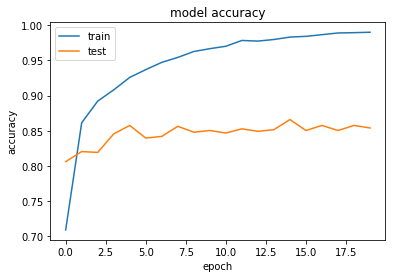

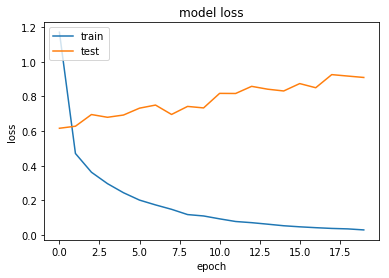

In [40]:
#InceptionV3
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

history = InceptionV3_model.fit(train_InceptionV3, train_targets, 
          validation_data=(valid_InceptionV3, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

# Visualizing the CNN 
#1) For Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#2) For loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The visualisation code was taken from the link : https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/ 

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 4s 579us/step - loss: 0.2565 - acc: 0.9208 - val_loss: 0.5053 - val_acc: 0.8527

Epoch 00001: val_loss improved from inf to 0.50526, saving model to saved_models/weights.best.Xception.hdf5
Epoch 2/20
6680/6680 [==============================] - 3s 410us/step - loss: 0.2209 - acc: 0.9325 - val_loss: 0.5004 - val_acc: 0.8647

Epoch 00002: val_loss improved from 0.50526 to 0.50039, saving model to saved_models/weights.best.Xception.hdf5
Epoch 3/20
6680/6680 [==============================] - 3s 414us/step - loss: 0.1972 - acc: 0.9401 - val_loss: 0.5098 - val_acc: 0.8659

Epoch 00003: val_loss did not improve from 0.50039
Epoch 4/20
6680/6680 [==============================] - 3s 410us/step - loss: 0.1833 - acc: 0.9442 - val_loss: 0.5516 - val_acc: 0.8515

Epoch 00004: val_loss did not improve from 0.50039
Epoch 5/20
6680/6680 [==============================] - 3s 413us/step - loss: 0.163

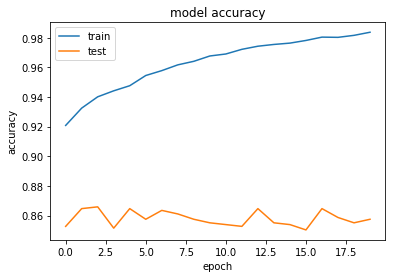

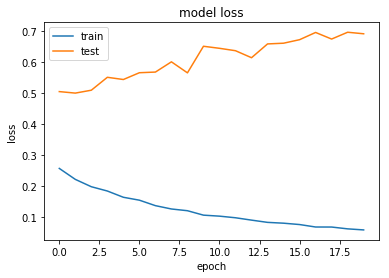

In [44]:
#Xception
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

history = Xception_model.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The visualisation code was taken from the link : https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/ 

### Load the Model with the Best Validation Loss

In [41]:
#InceptionV3
InceptionV3_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')

In [45]:
#Xception
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')

### Test the Model

In [43]:
#InceptionV3
# get index of predicted dog breed for each image in test set
InceptionV3_predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

# report test accuracy
test_accuracy = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 77.8708%


In [46]:
#Xception
# get index of predicted dog breed for each image in test set
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 85.0478%


Of the models tested, The Xception model gives the best accuracy for the test set. Hence this model is used in the further tasks of this project.

### Predict Dog Breed with the Model


In [33]:
#Xception
from extract_bottleneck_features import *

def Xception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Xception_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

## Step 6: Final Algorithm 

The following algorithm will detect the presence of humans or dogs in the image. 
If a dog is detected, the algorithm predicts the breed of the dog.
If a human is detected, the algorithm prints the human face and gives a dog breed that resembles the most with the face :P
If neither is detected, the algorithm prints error.

In [38]:
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [39]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [64]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def prediction(path2img):
    img = mpimg.imread(path2img)
    human_detected = face_detector(path2img)
    dog_detected = dog_detector(path2img)
    #path2img = cv2.cvtColor(path2img, cv2.COLOR_BGR2RGB)
    if human_detected == True :
        print ("Hello Homosapien! ")
        
        plt.imshow(img)
        plt.show()
        
        print("Your face is similar to the dog_breed: " + Xception_predict_breed(path2img))
    elif dog_detected == True :
        print("This doggie looks like " + Xception_predict_breed(path2img))
        plt.imshow(img)
        plt.show()
        
    else :
        plt.imshow(img)
        plt.show()
        print ("Error! \n Input image contains neither a human nor a dog")

## Step 7: Testing the  Algorithm

Hello Homosapien! 


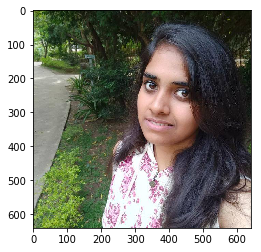

Your face is similar to the dog_breed: Newfoundland


In [62]:
prediction("images/cheth.jpg")

This doggie looks like Labrador_retriever


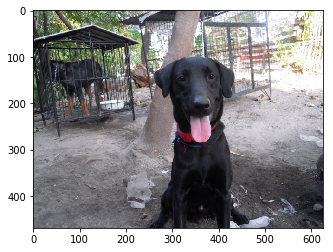

In [65]:
prediction("images/Labrador_retriever_06449.jpg")

Hello Homosapien! 


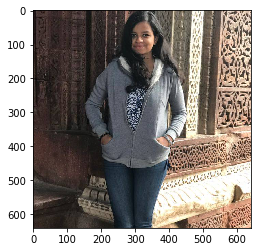

Your face is similar to the dog_breed: Cavalier_king_charles_spaniel


In [68]:
prediction("images/varsha.jpg")

This doggie looks like Brittany


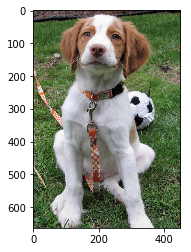

In [69]:
prediction("images/Brittany_02625.jpg")

This doggie looks like Welsh_springer_spaniel


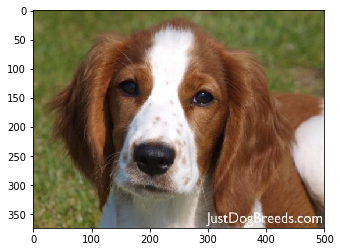

In [70]:
prediction("images/Welsh_springer_spaniel_08203.jpg")

Hello Homosapien! 


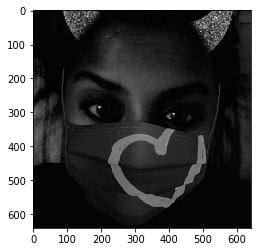

Your face is similar to the dog_breed: Boston_terrier


In [71]:
prediction("images/kay.jpg")

The model has performed well on the dog images. It has also performed better than as expected in the human dataset. The algorithm did predict the last image correctly as human despite the extra added effects to the face.